In [1]:
import mediapipe as mp
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

<function matplotlib.pyplot.show(close=None, block=None)>

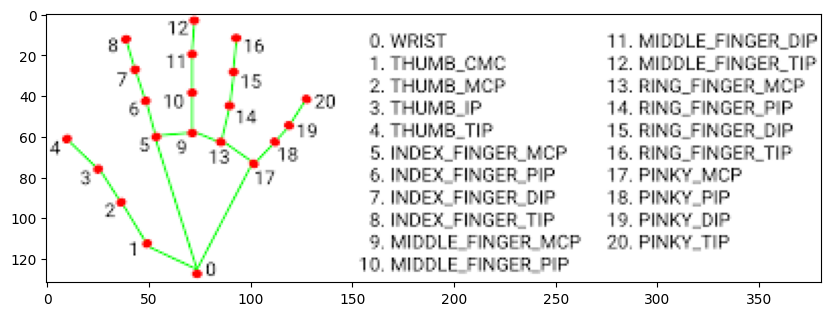

In [2]:
plt.figure(figsize=(10, 10))
img = plt.imread(r"F:\Computer Vision\MediaPipe\handlandmarks.png")
plt.imshow(img)
plt.show

In [2]:
liked_img = cv2.imread("like.png")
liked_img = cv2.resize(liked_img, (120, 100))

disliked_img = cv2.imread("dislike.png")
disliked_img = cv2.resize(disliked_img, (120, 100))


In [27]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils

finger_tips = [8, 12, 16, 20]

thumb_tip = 4

landmarks_list = []
finger_fold_state = []
Stop_state = []
Forwar_state = []
Backward_state = []
Right_state = []
Left_state = []

cap = cv2.VideoCapture(0)

prev_time = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    else:
        frame = cv2.resize(frame, (1100, 700))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        h, w, s = frame.shape
        Lh, Lw, Ls = liked_img.shape
        Dh, Dw, Ds = disliked_img.shape
        
        landmarks_list.clear()
        finger_fold_state.clear()
        Stop_state.clear()
        Forwar_state.clear()
        Backward_state.clear()
        Right_state.clear()
        Left_state.clear()
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                for idx, landmark in enumerate(hand_landmarks.landmark):
                    landmarks_list.append(landmark)
                for tip in finger_tips:
                    x, y = int(landmarks_list[tip].x * w), int(landmarks_list[tip].y * h)
                    cv2.circle(frame, (x, y), 15, [0, 255, 0], cv2.FILLED)
                    
                    # Like with right hand
                    if (landmarks_list[tip].x > landmarks_list[tip-3].x):
                        if landmarks_list[0].x > (landmarks_list[tip-3].x):
                            finger_fold_state.append(1)
                            cv2.circle(frame, (x, y), 15, [255, 0, 0], cv2.FILLED)
                    # Like with left hand       
                    if (landmarks_list[tip].x < landmarks_list[tip-3].x):
                        if landmarks_list[0].x < ( landmarks_list[tip-3].x):
                            finger_fold_state.append(1)
                            cv2.circle(frame, (x, y), 15, [255, 0, 0], cv2.FILLED)
                    
                    # Stop sign
                    if (landmarks_list[tip].y < landmarks_list[tip-2].y):
                        Stop_state.append(1)
                        if (landmarks_list[thumb_tip].x > landmarks_list[thumb_tip-2].x) and all(Stop_state) and len(Stop_state) == 4:
                            cv2.putText(frame, "Stop", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 2, [255, 0, 0], 2)
                            
                    # Forward
                    if landmarks_list[finger_tips[0]].y < landmarks_list[finger_tips[0]-3].y:
                        if tip == 8:
                            continue
                        elif landmarks_list[tip].y > landmarks_list[tip-3].y:
                            Forwar_state.append(1)
                            if ( landmarks_list[thumb_tip].x < landmarks_list[thumb_tip-1].x) and all(Forwar_state) and len(Forwar_state) == 3:
                                cv2.putText(frame, "Forward", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 2, [255, 0, 0], 2)
                    
                    # Backward
                    if landmarks_list[finger_tips[0]].y > landmarks_list[finger_tips[0]-3].y:
                        if tip == 8:
                            continue
                        elif landmarks_list[tip].y < landmarks_list[tip-3].y:
                            Backward_state.append(1)
                            if ( landmarks_list[thumb_tip].x < landmarks_list[thumb_tip-1].x) and all(Backward_state) and len(Backward_state) == 3:
                                cv2.putText(frame, "Backward", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 2, [255, 0, 0], 2)
                    
                    # Right
                    if landmarks_list[finger_tips[0]].x > landmarks_list[finger_tips[0]-3].x:
                        if tip == 8:
                            continue
                        elif landmarks_list[tip].x < landmarks_list[tip-3].x:
                            Right_state.append(1)
                            if len(Right_state) == 3 and all(Right_state) and landmarks_list[thumb_tip].x < landmarks_list[thumb_tip-1].x:
                                cv2.putText(frame, "Right", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 2, [255, 0, 0], 2)
                    
                    # Left
                    if landmarks_list[finger_tips[0]].x < landmarks_list[finger_tips[0]-3].x:
                        if tip == 8:
                            continue
                        elif landmarks_list[tip].x > landmarks_list[tip-3].x:
                            Left_state.append(1)
                            if len(Left_state) == 3 and all(Left_state) and landmarks_list[thumb_tip].y < landmarks_list[thumb_tip-2].y:
                                cv2.putText(frame, "Left", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 2, [255, 0, 0], 2)
                           
                    # else:
                    #     finger_fold_state.append(0)
                        
                # print(finger_fold_state)
                # Check about like sign
                if all(finger_fold_state) and len(finger_fold_state) == 4:
                    if landmarks_list[thumb_tip].y < landmarks_list[thumb_tip-1].y < landmarks_list[thumb_tip-2].y:
                        cv2.putText(frame, "Like", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 2, [255, 0, 0], 2)
                        frame[60:Lh+60, 10:Lw+10] = liked_img
                    else:
                        cv2.putText(frame, "Disike", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 2, [255, 0, 0], 2)
                        frame[60:Dh+60, 10:Dw+10] = disliked_img
        
        curr_time = time.time()
        fbs = int(1 / (curr_time - prev_time))
        prev_time = curr_time
        
        cv2.putText(frame, f"FBS: {fbs}", (10, 250), cv2.FONT_HERSHEY_COMPLEX, 2, [255, 0, 0], 2)      
                        
        cv2.imshow("Hand", frame)
        if cv2.waitKey(1) == 27:
            break
        
cap.release()
cv2.destroyAllWindows()
                    